In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from pathlib import Path


from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine, helper_functions

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.9.1
torchvision version: 0.24.1


/opt/anaconda3/envs/food-vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'mps'

In [3]:
# Download data using helper function
image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                             destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [5]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)), # resize image to 224, 224 (height x width)
                                        transforms.ToTensor(), # get images into range [0, 1]
                                        normalize]) # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)

In [6]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x10549bc40>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [9]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [10]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False


In [11]:
len(class_names)

3

In [12]:
# Update the classifier head of our model to suit our problem
from torch import nn

helper_functions.set_seeds(seed=42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names))).to(device) # how many classes do we have?

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [13]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [14]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/envs/food-vision/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
 20%|██        | 1/5 [01:08<04:35, 68.91s/it]

Epoch: 1 | train_loss: 1.0842 | train_acc: 0.3867 | test_loss: 0.9148 | test_acc: 0.5085


 40%|████      | 2/5 [02:09<03:11, 63.80s/it]

Epoch: 2 | train_loss: 0.8721 | train_acc: 0.7734 | test_loss: 0.7976 | test_acc: 0.7434


 60%|██████    | 3/5 [03:09<02:04, 62.12s/it]

Epoch: 3 | train_loss: 0.7900 | train_acc: 0.7891 | test_loss: 0.7347 | test_acc: 0.7633


 80%|████████  | 4/5 [04:10<01:01, 61.73s/it]

Epoch: 4 | train_loss: 0.7275 | train_acc: 0.7539 | test_loss: 0.6570 | test_acc: 0.8968


100%|██████████| 5/5 [05:10<00:00, 62.14s/it]

Epoch: 5 | train_loss: 0.6420 | train_acc: 0.7812 | test_loss: 0.6279 | test_acc: 0.9072
[INFO] Total training time: 310.750 seconds


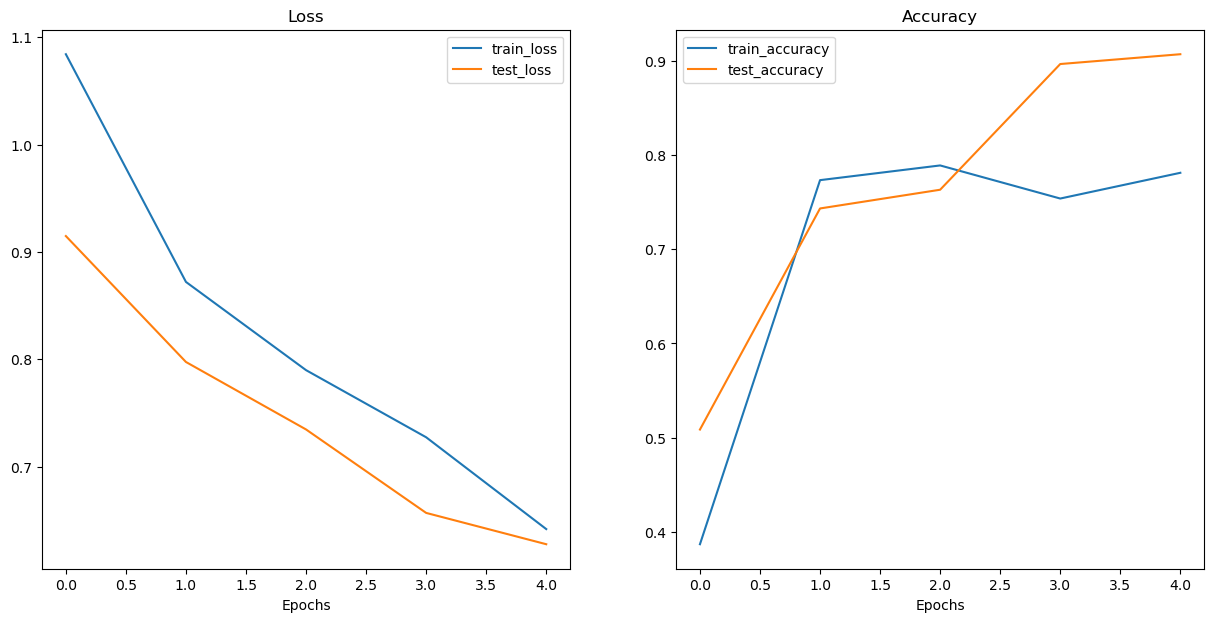

In [16]:
# Plot the loss curves of our model
helper_functions.plot_loss_curves(results)

In [21]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])
  
  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device)) 
  
  # 8. Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # print(target_image_pred_probs.max())

  # 9. Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

   # Get the ground truth label from the filepath
  target_image_true_label = Path(image_path).parent.name

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img) 
  plt.title(f"True: {target_image_true_label} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

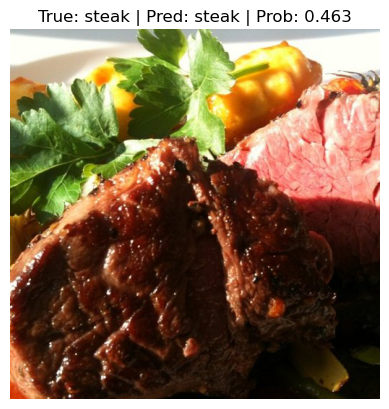

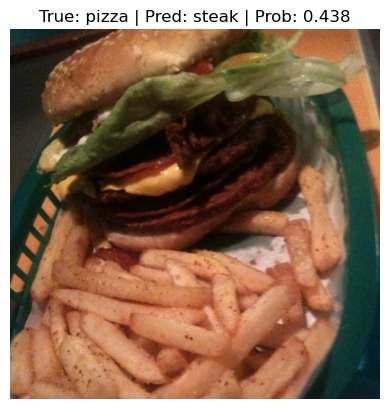

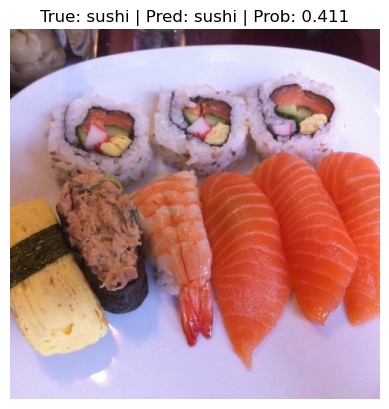

In [22]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))